<a href="https://colab.research.google.com/github/haujla2391/CSCI-4170/blob/main/CSCI4170_hw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW 2

Dataset: https://www.kaggle.com/datasets/nareshbhat/health-care-data-set-on-heart-attack-possibility

In [9]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

df = pd.read_csv("heart.csv")
print(df.shape)
print(df.info())

# Selecting numeric features
num_df = df.select_dtypes(include=["int64", "float64"])

# Add constant for VIF computation
X = num_df.copy()
X["Intercept"] = 1

vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [
    variance_inflation_factor(X.values, i)
    for i in range(X.shape[1])
]

vif_data.sort_values(by="VIF", ascending=False)

target_col = "target"

num_df = df.select_dtypes(include=["int64", "float64"])

X = num_df.drop(columns=[target_col]).values
y = num_df[target_col].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

(303, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB
None


## Task 1

Decision Tree Implementation

In [10]:
from sklearn import tree
import matplotlib.pyplot as plt

# classification_tree = tree.DecisionTreeClassifier()

# classification_tree = tree.DecisionTreeClassifier(max_depth=225)            70 percent
# classification_tree = tree.DecisionTreeClassifier(min_samples_split=17)     80 percent
# classification_tree = tree.DecisionTreeClassifier(max_features=15)          72 percent

classification_tree = tree.DecisionTreeClassifier(max_depth=225, min_samples_split=17, max_features=15)     # 80 percent

classification_tree = classification_tree.fit(X_train, y_train)

preds_Tree = classification_tree.predict(X_test)

accuracy = np.sum(preds_Tree == y_test) / len(y_test)
print(accuracy)

0.8032786885245902


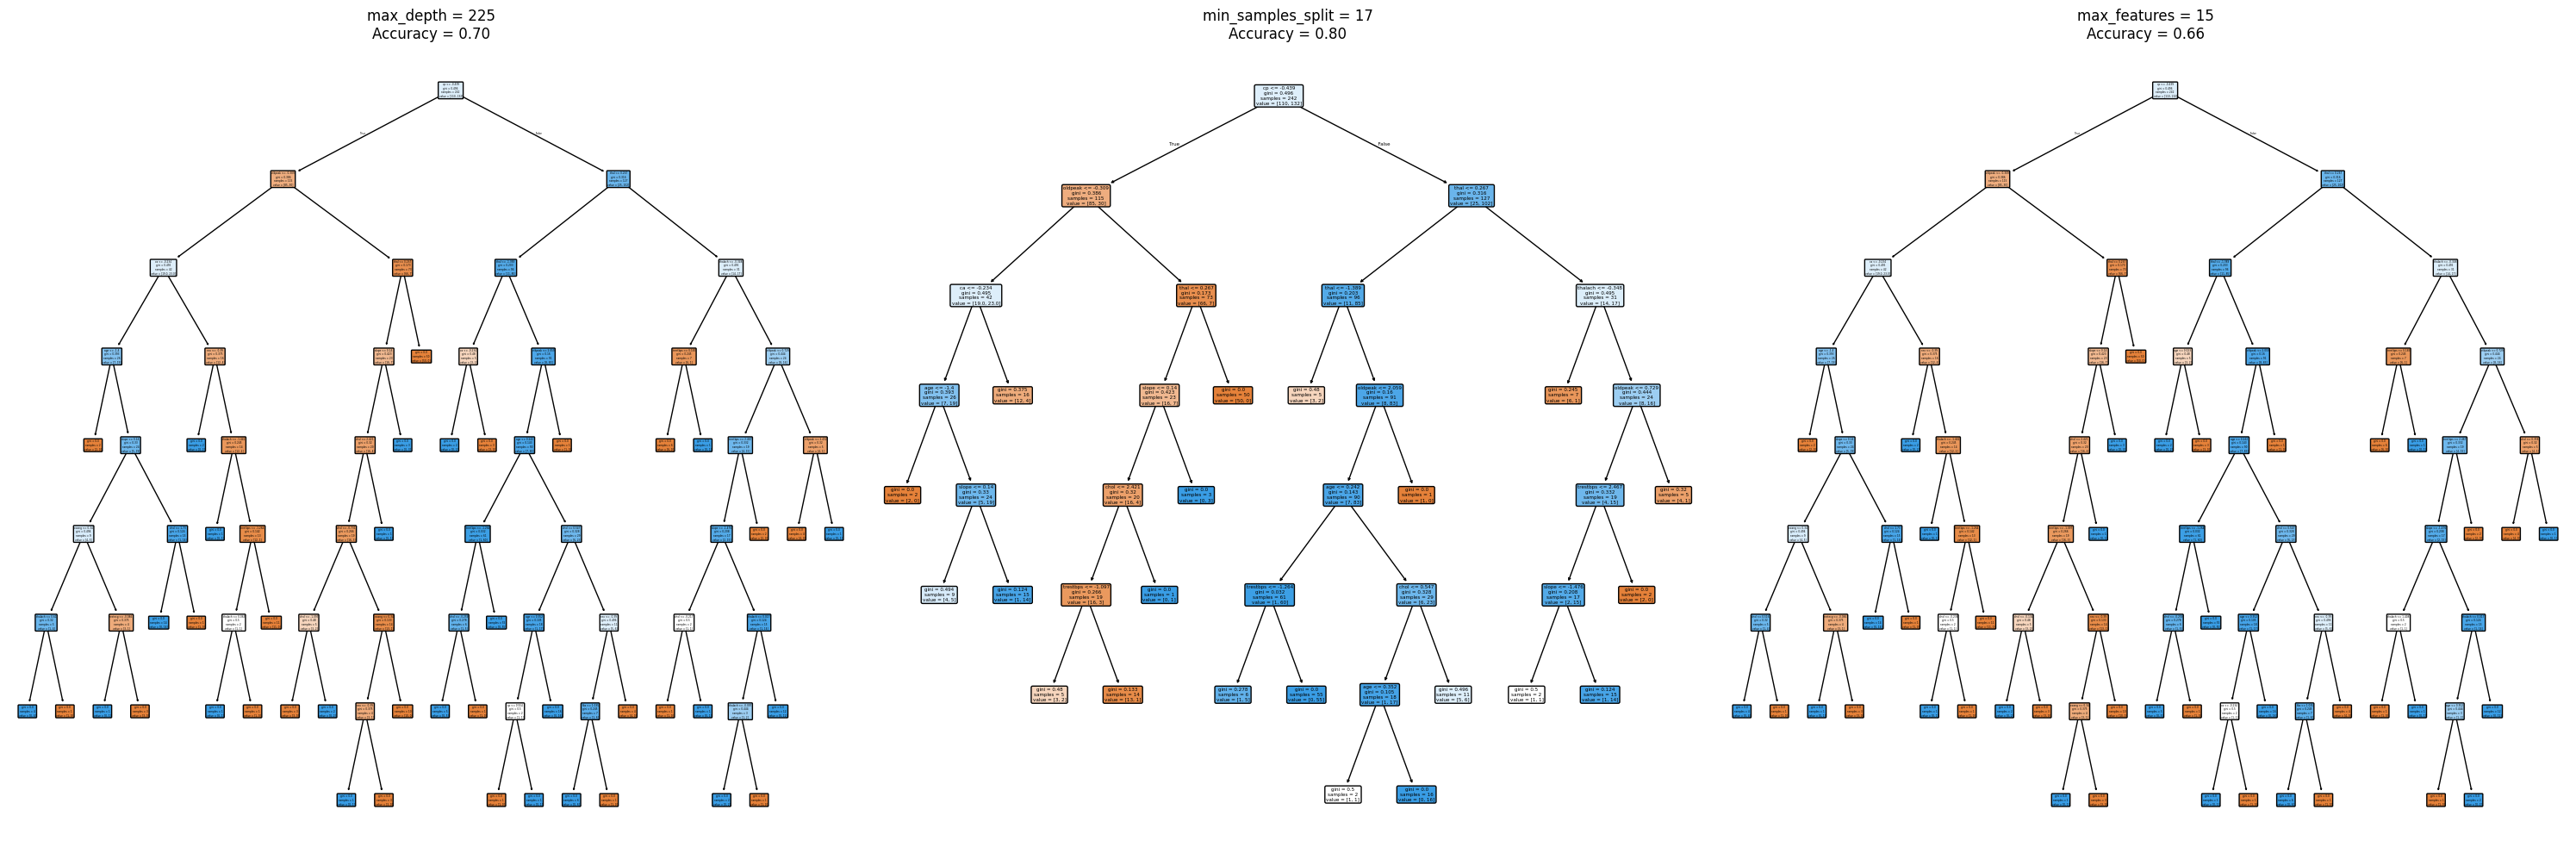

In [11]:
from sklearn import tree
import matplotlib.pyplot as plt

models = {
    "max_depth = 225": tree.DecisionTreeClassifier(max_depth=225),
    "min_samples_split = 17": tree.DecisionTreeClassifier(min_samples_split=17),
    "max_features = 15": tree.DecisionTreeClassifier(max_features=15),
}

feature_names = num_df.drop(columns=[target_col]).columns.tolist()

fig, axes = plt.subplots(1, 3, figsize=(30, 10))

for ax, (title, model) in zip(axes, models.items()):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = (preds == y_test).mean()

    tree.plot_tree(
        model,
        feature_names=feature_names,
        filled=True,
        rounded=True,
        ax=ax
    )

    ax.set_title(f"{title}\nAccuracy = {acc:.2f}")

plt.tight_layout()
plt.show()

The depth changes the tree by having lower (200) be around 70 percent accuracy, due to not being as complex, and then higher (500) be around the same due to overfitting. Having a sweet spot of around 225-250 gives the best accuracy of 72 percent. The other features also have a sweet spot and the `min_samples_split` was the biggest improver of accuracy. This is most likely due to some nodes not being as important and having unnecessary splits.

In [12]:
def sens_anal(feature_index, test_data_X, test_data_Y):
  X_perturbed = test_data_X.copy()
  X_perturbed[:, feature_index] = np.random.permutation(X_perturbed[:, feature_index])
  preds = classification_tree.predict(X_perturbed)
  return np.sum(preds == test_data_Y) / len(test_data_Y)

acc1 = sens_anal(0, X_test, y_test)
acc2 = sens_anal(7, X_test, y_test)

print(accuracy)
print(acc1)
print(acc2)


0.8032786885245902
0.7540983606557377
0.819672131147541


We can see that changing `age` made a big difference in the accuracy, making it worse. Perturbing `thalach` made an improvement in the accuracy meaning that it isn't as important as `age` but still enough to help our accuracy.

## Task 2

Bagging Algorithm: Random Forest

In [13]:
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=42)

# cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
cv = RepeatedStratifiedKFold(n_splits=15, n_repeats=3, random_state=1)
cv_scores_rf = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

print('CV Stability (Train Set): %.3f (%.3f)' % (np.mean(cv_scores_rf), np.std(cv_scores_rf)))

model.fit(X_train, y_train)

preds_Forest = model.predict(X_test)
print('Final Holdout Accuracy:', np.sum(preds_Forest == y_test) / len(y_test))

CV Stability (Train Set): 0.821 (0.082)
Final Holdout Accuracy: 0.8360655737704918


Boosting Algorithm: XG Boost

In [14]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

base = DecisionTreeClassifier(max_depth=2)
model = AdaBoostClassifier(estimator=base)

# cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
cv = RepeatedStratifiedKFold(n_splits=15, n_repeats=3, random_state=1)
cv_scores_ada = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

print('CV Stability (Train Set): %.3f (%.3f)' % (np.mean(cv_scores_ada), np.std(cv_scores_ada)))

model.fit(X_train, y_train)

preds_Boost = model.predict(X_test)
print('Final Holdout Accuracy:', np.sum(preds_Boost == y_test) / len(y_test))

CV Stability (Train Set): 0.773 (0.085)
Final Holdout Accuracy: 0.8032786885245902


We can see that with 5 splits, the CV Stability is: 0.823 (0.057). With 10 splits: 0.822 (0.083), and with 15 splits is: 0.821 (0.082). So these splits do not cause much change in the accuracies.

For the boosting algorithm:

5: 0.814 (0.057) \
10: 0.810 (0.072) \
15: 0.806 (0.076)

In [15]:
from sklearn.metrics import precision_score, f1_score, classification_report

print("\nAdaBoost:")
print(classification_report(y_test, preds_Boost))
print("\nRandomForest:")
print(classification_report(y_test, preds_Forest))


AdaBoost:
              precision    recall  f1-score   support

           0       0.86      0.68      0.76        28
           1       0.77      0.91      0.83        33

    accuracy                           0.80        61
   macro avg       0.82      0.79      0.80        61
weighted avg       0.81      0.80      0.80        61


RandomForest:
              precision    recall  f1-score   support

           0       0.95      0.68      0.79        28
           1       0.78      0.97      0.86        33

    accuracy                           0.84        61
   macro avg       0.87      0.82      0.83        61
weighted avg       0.86      0.84      0.83        61



Ranking based on accuracy, F1, and precision: \
1. Random Forest
2. AdaBoostClassifier

So, the Random Forest seems like it is a better model for this dataset. Both models share a slight bias toward Class 1, but the Random Forest manages this trade-off much more efficiently, providing a more stable and trustworthy performance across all metrics.

## Task 3

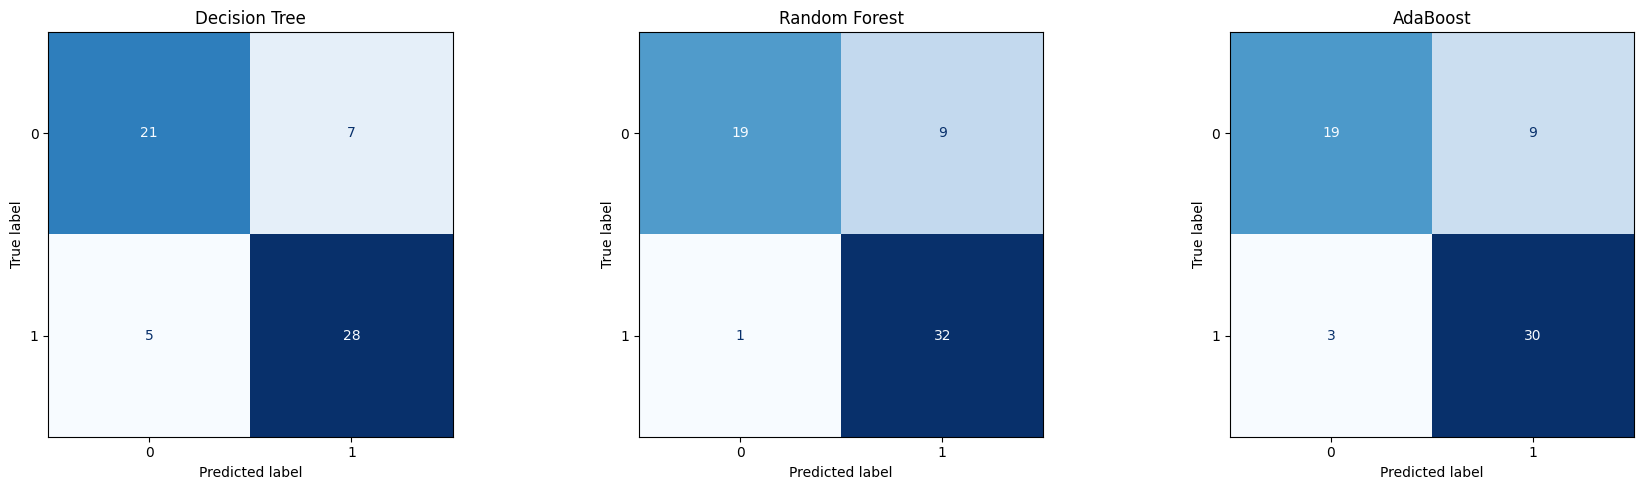

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

results = {
    "Decision Tree": preds_Tree,
    "Random Forest": preds_Forest,
    "AdaBoost": preds_Boost
}

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, (name, preds) in enumerate(results.items()):
    cm = confusion_matrix(y_test, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=axes[i], cmap='Blues', colorbar=False)
    axes[i].set_title(name)

plt.tight_layout()
plt.show()

In [17]:
from scipy import stats

t_stat, p_val = stats.ttest_rel(cv_scores_rf, cv_scores_ada)

print(f"P-value: {p_val:.4f}")

if p_val < 0.05:
    print("The difference is statistically significant (reject H0).")
else:
    print("The difference is likely due to chance (fail to reject H0).")

P-value: 0.0003
The difference is statistically significant (reject H0).


The bias vs variance for the decision tree is that there is high variance and low bias. The random forest model has lower variance because of bagging and the AdaBoost lowers bias a little by boosting.